## 3D UNet for segmentation of the liver and spleen

Inspiration for improvements: **nnU-Net: Self-adapting Framework
for U-Net-Based Medical Image Segmentation** (https://arxiv.org/pdf/1809.10486.pdf)

In [1]:
# imports
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
from scipy.ndimage import label as scipy_label
import json
import warnings
from random import randint
import random
import SimpleITK as sitk
from multi_slice_viewer import multi_slice_viewer
from IPython.display import clear_output
import pickle 
from tqdm import tqdm_notebook as tqdm
import warnings
import h5py
import ipywidgets

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, MaxPooling3D, Dropout, Conv3DTranspose, UpSampling3D, concatenate, Cropping3D, Reshape, BatchNormalization
import keras.callbacks
from keras import backend as K
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from tensorflow.python.client import device_lib
from keras.utils import multi_gpu_model

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [ ]:
# check if we use gpu or cpu
print(device_lib.list_local_devices())
print(tf.test.is_gpu_available())
print(K.tensorflow_backend._get_available_gpus())

In [ ]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
assert len(K.tensorflow_backend._get_available_gpus()) > 0

In [ ]:
# Task03_liver dir in same directory as notebook
data_path = './Task09_Spleen/'

In [ ]:
# info about dataset in json file
with open(data_path + 'dataset.json') as f:
    d = json.load(f)   
    
    # paths to training set images with label
    train_paths = d['training']
    
    # paths to testset images without label
    test_paths = d['test'] 

In [ ]:
# change to data dir 
os.chdir(data_path)
print(os.getcwd())

In [ ]:
# paths to train files
train_imgs = [train_instance['image'] for train_instance in train_paths]
train_lbls = [train_instance['label'] for train_instance in train_paths]

## Resampling
Images do not have the same spacings. We will first resample. For this we need the spacings in the SITK images. Note that when converting sitk to numpy the z axis is placed at the front. Spacings in order: (x, y, z), numpy image: (z, y, x)

Resample to 1mm x 1mm x 1mm resolution => images should have different sizes (not all 512 x 512 x N anymore). 
For example, when the image has a shape of (512, 512, 74) and a spacing of (0.75, 0.75, 2),
you can calculate how wide the image is along the x-axis: 512 * 0.75 mm = 384 mm. As a tip, look for “scipy zoom”.

In [ ]:
# now load one image and label at a time
def resample_and_save(paths, order, filename):     
    print('Storing resampled dataset at {}.'.format(os.path.join(os.getcwd(), filename)))    
    
    # make a h5py file to store images as numpy in
    with h5py.File(filename, 'w') as f: 
        for i, path in enumerate(tqdm(paths)):            
            
            # read the image
            img = sitk.ReadImage(path)
            
            # get the spacing
            spacing = img.GetSpacing()
            
            # change order
            x, y, z = spacing           
            spacing = (z, y, x)      # swap x and z

            # convert to numpy
            np_img = sitk.GetArrayFromImage(img)

            # apply zoom
            np_img_re = zoom(np_img, spacing, order=order)
            
            print("Index: {}, before: {}, spacing: {}, after: {}".format(i, np_img.shape, spacing, np_img_re.shape))

            # save the resamples img/label
            dataset = f.create_dataset(str(i), data=np_img_re)      

In [ ]:
# use order 3 interpolation for imgs, order 0 for labels (neigherest neighbour interpolation)
# resample_and_save(train_imgs, order=3, filename='spleen_resampled_train_imgs.h5py')
# resample_and_save(train_lbls, order=0, filename='spleen_resampled_train_lbls.h5py')

## Loading the  train data
Start here if you saved the resampled images and labels.

In [2]:
# change to data dir
data_path = './Task09_Spleen/'
os.chdir(data_path)
print(os.getcwd())

/nfs/home4/mbotros/ISMI_project/Task09_Spleen


In [3]:
# load from disk, note that the keys are not in order, for the test set load in order
np_train_imgs = []
np_train_lbls = []

with h5py.File('spleen_resampled_train_imgs.h5py', 'r') as f: 
    for img in tqdm(f):
        dset = f[img]
        np_train_imgs.append(dset[:])
    
with h5py.File('spleen_resampled_train_lbls.h5py', 'r') as f: 
    for lbl in tqdm(f):
        dset = f[lbl]     
        np_train_lbls.append(dset[:])

## Frequency of the labels
This might be useful for later if we need class weights.

In [4]:
# count the labels of train images
sums = np.zeros(3)
for lbs in tqdm(np_train_lbls):
    labels, counts = np.unique(lbs, return_counts=True)
    
    # if there are only 2 labels
    if len(counts) == 2:
        sums[:2]+=counts
    else:
        sums+=counts

In [5]:
# print percentages of voxels.
total = sum(sums)
print("{:.2f}% background, {:.2f}% spleen, {:.2f}% cancer.".format(sums[0]/total*100, sums[1]/total*100, sums[2]/total*100))

99.60% background, 0.40% liver, 0.00% cancer.


In [6]:
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None: 
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial', overlay_1=self.lbls[i], overlay_1_thres=1, 
                   overlay_2=self.lbls[i], overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)
        else:
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial')  

# Split for training and validation
During training we want to select the best model, which is done with the validation set (unseen data for the model).

In [7]:
# split into training set and validation set
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)
n_validation_imgs = int(validation_percent * len(np_train_imgs))

val_set   = DataSet(np_train_imgs[:n_validation_imgs], np_train_lbls[:n_validation_imgs])
train_set = DataSet(np_train_imgs[n_validation_imgs:], np_train_lbls[n_validation_imgs:])

print('{} images in val set'.format(val_set.get_lenght()))
print('{} images in train set'.format(train_set.get_lenght()))

8 images in val set
33 images in train set


# Patch extractor
We re-use the patch extractor from assignment 7, but modify it to get 3D patches from a 3D image.
We can add augmentations later in the patch extractor. Note the extra dimension in the shape of patch_out and target_out. 

In [8]:
class PatchExtractor:

    def __init__(self, patch_size, fromSpleen):
        self.patch_size = patch_size 
        self.fromSpleen = fromSpleen
    
    def get_patch(self, image, label):
        ''' 
        Get a 3D patch of patch_size from 3D input image, along with corresponding 3D label map.
        Pick random location of the patch inside the image. The point is at the center of the patch.
        We first pad the image to not go out of bounds when extracting the patch.
        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        '''
        
        # size of patch in each dimension
        pz, px, py = self.patch_size
        
#         print('Patch_size: {}'.format(patch_size))
#         print('Image_size: {}'.format(image.shape))

        # pad with the min value in the image
        min_val = np.min(image)
        
        # pad with half the patch size, I assume even patch size
        padded_img = np.pad(image, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant', constant_values=min_val)
        padded_lbl = np.pad(label, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant')
        
#         print('Padded_size: {}'.format(padded_img.shape))

        # random between [0., 1.), if fromSpleen is true takes 75% of patches from spleen
        p = random.random()

        # centre of the patch: a random point from the spleen in the non padded image
        if self.fromSpleen and p > 0.25:
            
            # getting the spleen labeled points
            liver_ind = np.argwhere(label == 1)  
            
            # get a random point from the spleen labeled points
            r = randint(0, len(liver_ind))
            z = liver_ind[r][0]
            x = liver_ind[r][1]
            y = liver_ind[r][2]
            
        # centre of the patch: a random location in the non padded image    
        else:
            dims = image.shape
            z = randint(0, dims[0]) 
            x = randint(0, dims[1]) 
            y = randint(0, dims[2])   
            
        # z, x, y is the left bottom corner of the patch in the padded image (index shift with pad size)     
        # take a patch, with the random point at the center in the padded img
        patch  = padded_img[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)
        target = padded_lbl[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)

        return patch, target

(156, 156, 156, 1)
(156, 156, 156, 1)


<IPython.core.display.Javascript object>


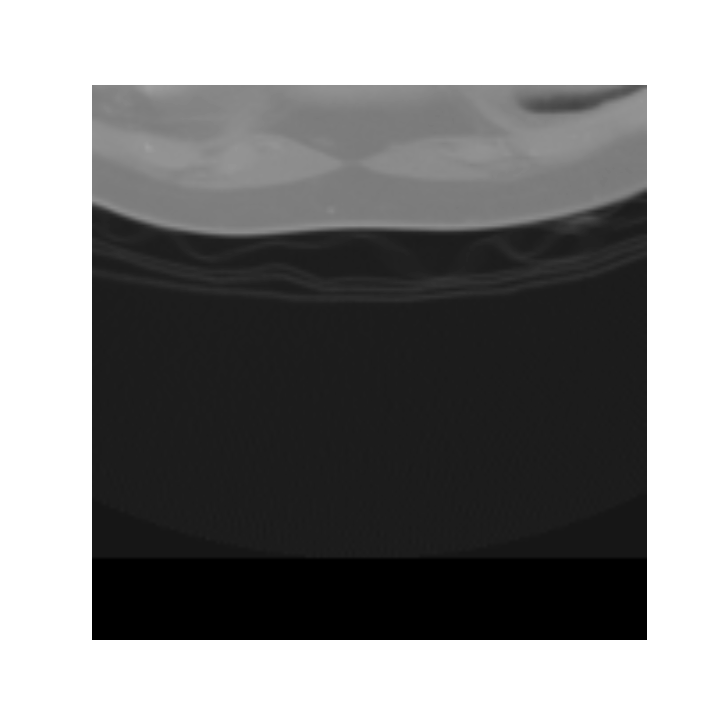

In [9]:
# get an image and a label from our train set
image = train_set.imgs[0]
label = train_set.lbls[0]

# test PatchExtractor
patch_size = (156, 156, 156)
patch_extractor = PatchExtractor(patch_size=patch_size, fromSpleen=True)

# lets check some patches
patch, target = patch_extractor.get_patch(image, label)

print(patch.shape)
print(target.shape)

# show patch
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(patch.reshape(patch_size), view='axial', overlay_1=target.reshape(patch_size), overlay_1_thres=1, 
                   overlay_2=target.reshape(patch_size), overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

# Batch creator
Lets also reuse the batch creator from assignment 7. We are going to use valid convolutions, which means the output of our network will be smaller than the input. The purpose of this batchcreator is the make batches consisting of patches with their corresponding labels (for the network to train on). Since a UNet with valid convolutions has a smaller output than input, we need to crop the label based on the target size aswell. And labels should be in onehot.

In [10]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, target_size):
        self.patch_extractor = patch_extractor
        self.target_size = target_size # size of the output, can be useful when valid convolutions are used        
        self.imgs = dataset.imgs
        self.lbls = dataset.lbls                
        self.n = len(self.imgs)
        self.patch_size = self.patch_extractor.patch_size
    
    def create_image_batch(self, batch_size):
        '''
        returns a single (batch of?) patches (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 1))  # 1 channel
        y_data = np.zeros((batch_size, *self.target_size, 2)) # one-hot encoding with 2 classes
        
        for i in range(0, batch_size):
        
            random_index = np.random.choice(len(self.imgs))                   # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index]       # get image and segmentation map
            
            # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
            img = np.clip(img, -1000, 3000)
            img = (img - np.min(img)) / np.ptp(img)     
            
            # get a patch with corresponding labels from the patch extractor
            patch_img, patch_lbl = self.patch_extractor.get_patch(img, lbl)   
            
            # crop labels based on target_size           
            ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2    
            pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            pd = (self.patch_extractor.patch_size[2] - self.target_size[2]) // 2
            
            # take the cropped patch, it contains labels with values 0,1,2
            cropped_patch = patch_lbl[ph:ph+self.target_size[0], pw:pw+self.target_size[1], pd:pd+self.target_size[2]].squeeze()
            
            # instead of 0,1,2 label values we want categorical/onehot => 0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]
            onehot = to_categorical(cropped_patch, num_classes=2)
            
            x_data[i, :, :, :, :] = patch_img
            y_data[i, :, :, :, :] = onehot
        
        return (x_data.astype(np.float32), y_data.astype(np.float32))
    
    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)

# 3D UNet Model
Start with this model, we can adapt this later if needed. Build like the net from: 
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.

In [11]:
# make block of two convolve3D's
def unet_block(inputs, n_filters, padding, up_conv=False, batchnorm=False):
    # 3d convolve, 32 3x3x3 filters 
    c1 = Conv3D(n_filters, (3,3,3), activation='relu', padding=padding, kernel_initializer='he_normal')(inputs)
    if batchnorm:
        c1 = BatchNormalization()(c1)
    
    # up conv (normal conv in the expanding path) has same number of filters twice
    if up_conv:
        c2 = Conv3D(n_filters, (3, 3, 3), activation='relu', padding=padding, kernel_initializer='he_normal')(c1)
    else:          # normal convs have twice the filters in the second conv
        c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', padding=padding, kernel_initializer='he_normal')(c1)
        
    if batchnorm:
        c2 = BatchNormalization()(c2)
    
    return c2

In [12]:
# 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.
def build_unet_3d(initial_filters, padding, batchnorm=True, print_model=False):
    
    ## CONTRACTING PATH
    
    # (spac_dim_1, space_dim_2, space_dim_3, channels)
    inputs = Input(shape=(156, 156, 156, 1))

    # First conv pool, 32 filters and 64 filters    
    block_1    = unet_block(inputs, initial_filters, padding=padding, batchnorm=batchnorm) 
    max_pool_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_1)  # 2×2×2 max pooling with strides two
                                                                        # needs even spacial_dimensions as input
    # second conv pool, 64 filters, 128 filters    
    block_2    = unet_block(max_pool_1, initial_filters*2, padding=padding, batchnorm=batchnorm)
    max_pool_2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_2)
    
    # third conv pool, 128 filters, 256 filters    
    block_3    = unet_block(max_pool_2, initial_filters*4, padding=padding, batchnorm=batchnorm)
    max_pool_3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_3)
    
    # just a conv block without maxpooling, 256 filters and 512 filters
    conv_4     = unet_block(max_pool_3, initial_filters*8, padding=padding, batchnorm=batchnorm)
    
    ## EXPANDING PATH   
        
    # round 1
    up_conv_3  = Conv3DTranspose(16*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(conv_4)
    crop_3     = Cropping3D(cropping=4)(block_3) 
    concat_3   = concatenate([crop_3, up_conv_3])  
    up_block_3 = unet_block(concat_3, 8*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 2
    up_conv_2  = Conv3DTranspose(8*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_3) 
    crop_2     = Cropping3D(cropping=16)(block_2) 
    concat_2   = concatenate([crop_2, up_conv_2])  
    up_block_2 = unet_block(concat_2, 4*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 3
    up_conv_1  = Conv3DTranspose(4*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_2) 
    crop_1     = Cropping3D(cropping=40)(block_1) 
    concat_1   = concatenate([crop_1, up_conv_1])  
    up_block_1 = unet_block(concat_1, 2*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # finish with 1x1x1 conv, 2 filters, #labels, softmax
    finish = Conv3D(2, (1,1,1), activation='softmax', padding=padding)(up_block_1)
    
    model = Model(inputs, finish) 
    
    if print_model:
        print(model.summary(line_length=150))
    
    return model

In [13]:
unet_3d = build_unet_3d(initial_filters=32, padding='valid', batchnorm=False, print_model=True)

Instructions for updating:
Colocations handled automatically by placer.
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             (None, 156, 156, 156, 1)         0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 154, 154, 154, 32)        896               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv3d_2 (Conv3D)     

## Testing the batch generator

(batch, d, h, w, channels)
xdata has shape: (2, 156, 156, 156, 1)
ydata has shape: (2, 68, 68, 68, 2)
Occuring values in true labels: [ 0.  1.]
Min of input: 0.0
Max of input: 0.7082569003105164


<IPython.core.display.Javascript object>


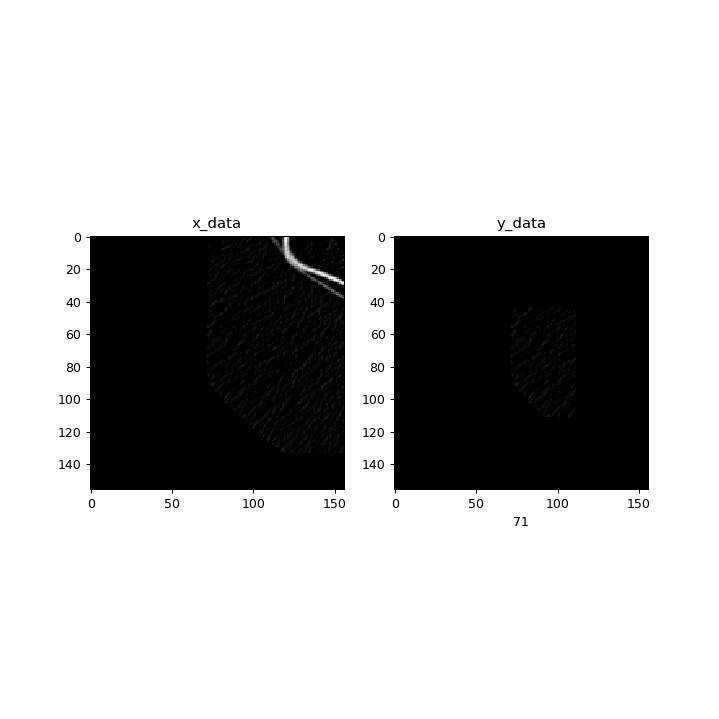

In [14]:
# define parameters for the batch creator
patch_size  = (156, 156, 156)  # isotropic patch size
target_size = (68, 68, 68)     # output size, smaller since valid convolutions are used
batch_size  = 2                # number of patches in a mini-batch, for segmentation 1 is fine, since the 
                               # output of the net is many thousands of values per patch, which all contribute to the loss

# initialize patch generator and batch creator
patch_generator       = PatchExtractor(patch_size, fromSpleen=True)
batch_generator_train = BatchCreator(patch_generator, train_set, target_size=target_size)
batch_generator_val   = BatchCreator(patch_generator, val_set, target_size=target_size)

# get one minibatch
x_data, y_data = batch_generator_train.create_image_batch(batch_size)

print("(batch, d, h, w, channels)")
print('xdata has shape: {}'.format(x_data.shape))
print('ydata has shape: {}'.format(y_data.shape))
print('Occuring values in true labels: {}'.format(np.unique(y_data)))
print('Min of input: {}'.format(np.min(x_data)))
print('Max of input: {}'.format(np.max(x_data)))

# show the patches, to check the batchcreator, mid slice
x = patch_size[0] // 2
patch = x_data[0, x, :, :].squeeze()

# get labels from one hot
label = np.argmax(y_data[0, :, :, :], axis=-1)

# labels were cropped, so pad them
p = (patch_size[0] - target_size[0]) // 2
padded_lbl = np.pad(label, ((p, p), (p, p), (p, p)), 'constant', constant_values=3.)

# makes masks to plot label overlay
masked_crop = np.ma.masked_where(padded_lbl != 3, padded_lbl)
masked_lbl  = np.ma.masked_where(padded_lbl == 0, padded_lbl)

# take the mid slice aswell
masked_lbl  = masked_lbl[x, :, :]            
masked_crop = masked_crop[x, :, :]

# show x_data (no labels) and y_data, which are the labels for the center crop of x_data
# y_data is plotted with padding to check
plt.figure()
plt.subplot(1, 2, 1, title='x_data')
plt.imshow(patch, cmap='gray')
plt.subplot(1, 2, 2, title='y_data')
plt.imshow(patch, cmap='gray')
plt.imshow(masked_lbl, cmap='coolwarm', alpha = 0.75)
plt.imshow(masked_crop, cmap='gray', alpha = 1)
plt.show()

## Define a logger which saves the losses and saves the best model

In [15]:
class Logger(keras.callbacks.Callback):

    # logg losses, removed accs for now
    def __init__(self, data_dir, model_name, base_model):  
        self.model_filename = os.path.join(data_dir, model_name + '.h5')        
        self.tr_losses = []  
        self.val_losses = []      
        self.best_val_loss = float("inf")   
        self.base_model = base_model
       
    def on_epoch_end(self, batch, logs={}):
        # add validation info
        self.val_losses.append(logs.get('val_loss'))
        self.tr_losses.append(logs.get('loss'))
        self.plot()

        # safe best model after epoch end
        if self.val_losses[-1] < self.best_val_loss:
            self.best_val_loss = self.val_losses[-1]
            
            # call save on the base model instead of the parallel model, both models share the same weights
            self.base_model.save(self.model_filename) # save best model to disk
            print('Best model saved as {}'.format(self.model_filename))
         
    def plot(self): 
        clear_output()
        plt.figure(figsize=(8, 4))
        n = len(self.val_losses) + 1         
        plt.plot(range(1, n), self.tr_losses, label='train loss')         
        plt.plot(range(1, n), self.val_losses, label='val loss')        
        plt.legend(loc='lower left')
        plt.show()

In [16]:
# make a data dir to store best model
print(os.getcwd())
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

/nfs/home4/mbotros/ISMI_project/Task09_Spleen


## Dice Loss 
------------------------------------------------
Dice loss seems to be a good pick for 3D segmentation with class inbalances. (see https://arxiv.org/pdf/1707.03237.pdf)

**Note that these are attempts for binary segmentation**

$$
\textbf{DL}_{2}=1-\frac{\sum_{n=1}^{N} p_{n} r_{n}+\epsilon}{\sum_{n=1}^{N} p_{n}+r_{n}+\epsilon}-\frac{\sum_{n=1}^{N}\left(1-p_{n}\right)\left(1-r_{n}\right)+\epsilon}{\sum_{n=1}^{N} 2-p_{n}-r_{n}+\epsilon}
$$

Let R be the reference foreground segmentation (gold standard) with voxel values $r_n$, and P the predicted probabilistic map for the foreground label over N image elements $p_n$, with the background class probability being 1 − P. 

Sudre, Carole H., et al. "Generalised dice overlap as a deep learning loss function for highly unbalanced segmentations." https://arxiv.org/pdf/1707.03237.pdf

In [17]:
def dice_loss_2(y_true, y_pred, epsilon=1e-6):
    ''' 
    Dice loss calculation in a binary classification (foreground vs. background) formulation.
    Assumes the channels_last format.
    y_true: One hot encoding of ground truth
    y_pred: Network output, must sum to 1 over c channel (such as after softmax) 
    '''
    # for every voxel of the prediction the probabililty of being foreground (liver
    P = K.sum(y_pred * K.constant([0., 1.]), axis=-1)   # shape = (b, z, h, w)
    
    # for every voxel of the groundtruth the label (0: background, 1: foreground)
    R = K.sum(y_true * K.constant([0., 1.]), axis=-1)   # shape = (b, z, h, w)
    
    a = K.sum(P * R, axis=(1, 2, 3)) 
    b = K.sum(P + R, axis=(1, 2, 3)) + epsilon
    c = K.sum((1. - P) * (1. - R), axis=(1, 2, 3)) 
    d = K.sum((2. - P - R), axis=(1, 2, 3)) + epsilon
    
    return 1 - a/b - c/d

$$ \textbf{DL}_3 =  1 - \frac{2 \hspace{0.3em}|X \cap Y|}{|X|+ |Y|} $$

In [18]:
def dice_loss_3(y_true, y_pred, epsilon=1e-6):
    ''' 
    Dice loss calculation.
    y_true: One hot encoding of ground truth
    y_pred: Network output, must sum to 1 over c channel (such as after softmax) 
    This seems correct to me.
    '''
    # for every voxel of the prediction the probabililty of being foreground (liver)
    P = K.sum(y_pred * K.constant([0., 1.]), axis=-1)   # shape = (b, d, h, w)
    
    # for every voxel of the groundtruth the label (0: background, 1: foreground)
    R = K.sum(y_true * K.constant([0., 1.]), axis=-1)   # shape = (b, d, h, w)
    
    #  |X| ∩ |Y|, true positives
    true_positives = K.sum(P * R, axis=(1, 2, 3))
    
    # this is |Y| number of voxels predicted to be fg (probabilities) 
    fg_voxels_p = K.sum(P, axis=(1, 2, 3))
    
    # this is |X|, should be the number of foreground voxels in the ground truth
    fg_voxels_r = K.sum(R, axis=(1, 2, 3))
    
    return 1. - (2. * true_positives + epsilon) / (fg_voxels_r + fg_voxels_p + epsilon)

## Testing loss functions

In [19]:
# test this loss function
loss_function = dice_loss_3

# all zeros and all ones in one hot        
all_bg = np.ones(shape=(2, 68, 68, 68, 2)) * [1, 0]
all_fg = np.ones(shape=(2, 68, 68, 68, 2)) * [0, 1]

# some fg in patch 1
some_fg  = np.copy(all_bg)
some_fg2 = np.copy(all_bg)
some_fg[0, :34, :34, :34]  = [0, 1]
some_fg2[0, :17, :17, :17] = [0, 1]

print('A bit of fg, predicts exactly that bit of fg:{}'.format(loss_function(some_fg, some_fg).eval(session=sess)))
print('A bit of fg, predicts exactly half of that bit of fg:{}'.format(loss_function(some_fg, some_fg2).eval(session=sess)))

print('All is bg, predicts all fg: {}'.format(loss_function(all_bg, all_fg).eval(session=sess)))
print('All is fg, predicts all bg: {}'.format(loss_function(all_fg, all_bg).eval(session=sess)))

print('Complete overlap in both patches fg: {}'.format(loss_function(all_fg, all_fg).eval(session=sess)))
print('Complete overlap in both patches bg: {}'.format(loss_function(all_bg, all_bg).eval(session=sess)))

A bit of fg, predicts exactly that bit of fg:[ 0.  0.]
A bit of fg, predicts exactly half of that bit of fg:[ 0.77777779  0.        ]
All is bg, predicts all fg: [ 1.  1.]
All is fg, predicts all bg: [ 1.  1.]
Complete overlap in both patches fg: [ 0.  0.]
Complete overlap in both patches bg: [ 0.  0.]


## Computing class weights
For training with a weighted Cross Entropy loss we need class weights. Frequent classes will contribute less to loss.
Instead of computing class weights from the whole train set, we might want to compute them from the batch in which we sample patches from the liver. This changes the foreground/background ratio.

In [20]:
# maybe we want class weight based on the fg/bg ratio in the patches
def compute_weights_from_batch(batch_gen, batch_size):
    '''
    Compute class weights for a given batch generator. 
    The weight for a class is computed as the inverse of its volume.
    batch_gen : the generator from which to get a batch
    batch_size: size of the batch the generator has to make
    '''
    # create a batch of batch_size
    x_data, y_data = batch_gen.create_image_batch(batch_size=batch_size)    
    labels = np.argmax(y_data, axis=-1)    
    l, counts = np.unique(labels, return_counts=True)
    
    print(l)
    print(counts) 
    
    # inverse of volume
    return 1 / counts

In [21]:
weights_from_batch = compute_weights_from_batch(batch_generator_train, batch_size=100)
print('Class weights from batch: {}'.format(weights_from_batch))

[0 1]
[22804497  8638703]
Class weights from batch: [  4.38510001e-08   1.15758118e-07]


## Now we define parameters, compile the model and train the network 
Inference is simpler with a batch size of 1, so we train with a parallel model which requires an even batch size and is faster, but save the weights from the base model. This way we can use it for inference later on.

In [22]:
# build model
unet_3d = build_unet_3d(initial_filters=32, padding='valid', batchnorm=False, print_model=False)

# parameters
learning_rate   = 3*10**-4
optimizer       = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
steps_per_epoch = 200
epochs          = 100
batch_size      = 2
logger          = Logger(data_dir, 'spleen-14-06', base_model=unet_3d)

# get generators
image_generator_train = batch_generator_train.get_image_generator(batch_size)
image_generator_val   = batch_generator_val.get_image_generator(batch_size)

# make parallel model for using two gpus
parallel_model = multi_gpu_model(unet_3d, gpus=2)                   # batchsize should be a multiple of #gpu's

# compile model
parallel_model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [23]:
# back to inline
%matplotlib inline

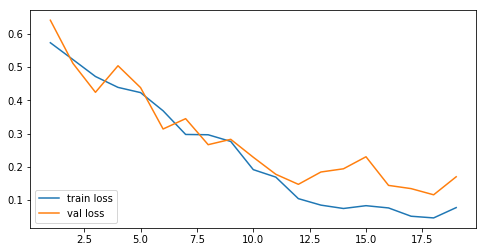

Epoch 20/100
 76/200 [==========>...................] - ETA: 17:47 - loss: 0.0492

In [ ]:
# train the model
parallel_model.fit_generator(generator=image_generator_train, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=image_generator_val, 
                    class_weight=weights_from_batch,
                    verbose=1,
                    validation_steps=25,
                    callbacks=[logger])

## Getting the full segmentation map
Like this but then 3D:

![seg_diagram.png](seg_diagram.png)


In [ ]:
def padding(image, patch_size, target_size):
    """
    Adding the red border (see example above) to the image. Which is needed for when we don't have full context. 
    Pad with lowest occuring values.
    image       : the input image (as numpy)
    patch_size  : patch_size of the input for the UNet
    target_size : output size of the model, needed to calculate how much to padd in each dimension. 
    """
    z, y, x = patch_size
    
    # pad with min value from image, always safe
    min_val = np.min(image)
    
    # size of padding for each dimension
    pad_z = (z - target_size[0]) // 2
    pad_x = (x - target_size[1]) // 2
    pad_y = (y - target_size[2]) // 2
    
    # pad with a tuple for how much on each side for every dimension
    padded_input = np.pad(image, ((pad_z, pad_z), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=min_val)
    
    return padded_input

In [ ]:
def predict_image_segmentation(model, image, target_size, patch_size):
    """
    Give a full segmentation map (same size as input_image) using the model. 
    model       : the model to do the prediction
    image       : the input image (as numpy)
    target_size : output size of the model (since we use valid convutions the output gets smaller)
    patch_size: : the size of the patch that is put into the model
    """
    
    # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
    image = np.clip(image, -1000, 3000)
    image = (image - np.min(image)) / np.ptp(image)    
    
    # pad the input image:
    pad_img = padding(image, patch_size, target_size)  

#     print("Image size: {}".format(image.shape))
#     print("Padded image size: {}".format(pad_img.shape))
    
    dims = image.shape
    # how many times target size fits in a dimension 
    pz = dims[0] // target_size[0] 
    px = dims[1] // target_size[1] 
    py = dims[2] // target_size[2] 
    
    # segmentation map, same size as input image
    segmentation = np.zeros(image.shape)   
    
    for z in range(pz, -1, -1):         
        for x in range(px, -1, -1):
            for y in range(py, -1, -1):  
                
                # shift starting point with target_size
                start_z = z * target_size[0]
                start_x = x * target_size[1]
                start_y = y * target_size[2]
                
                # if the patch does not fit:
                if start_z + patch_size[0] > pad_img.shape[0]:
                    start_z = pad_img.shape[0] - patch_size[0]
                if start_x + patch_size[1] > pad_img.shape[1]:
                    start_x = pad_img.shape[1] - patch_size[1]
                if start_y + patch_size[2] > pad_img.shape[2]:
                    start_y = pad_img.shape[2] - patch_size[2]
                
                # Get patch: shift with target_size, take patch_size                
                patch = pad_img[start_z:start_z + patch_size[0], 
                                start_x:start_x + patch_size[1], 
                                start_y:start_y + patch_size[2]]     

                # Reshape for u-net and make prediction:
                patch = np.reshape(patch, (1, patch_size[0], patch_size[1], patch_size[2], 1))
                prediction = model.predict(patch)

                # Put the prediction in segmentation map, shift with target_size, take target_size
                segmentation[start_z:start_z + target_size[0], 
                             start_x:start_x + target_size[1], 
                             start_y:start_y + target_size[2]] = np.argmax(np.squeeze(prediction), axis=3)
    
    return segmentation 

# Predictions for the validation set
To test the current model, we can inspect segmenations it makes for validation images to see whats going wrong.

In [ ]:
# declare data dir and patch/target size (needed to make a prediction as well)
data_dir = '../data'
patch_size  = (156, 156, 156)  # isotropic patch size
target_size = (68, 68, 68)     # output size, smaller since valid convolutions are used

# load best model
unet_3d = load_model(os.path.join(data_dir, 'test-08-06' + '.h5'))

In [ ]:
# segment every image in the validation set
val_set_seg = []

for image in tqdm(val_set.imgs):
    seg_map = predict_image_segmentation(unet_3d, image, target_size, patch_size)
    val_set_seg.append(seg_map)

## Save segmentations, before post processing.

In [ ]:
# save the segmentations to disk, because segmentation of 25 images takes 2-3 hours..
with h5py.File('val_set_segmentations.h5py', 'w') as f: 
    for i, seg in enumerate(tqdm(val_set_seg)):
        f.create_dataset(str(i), data=seg)          

## Load segmentations from disk

In [ ]:
val_set_segs = []

with h5py.File('val_set_segmentations.h5py', 'r') as f:     
    for i in tqdm(range(len(val_set.lbls))):
        dset = f[str(i)]     
        val_set_segs.append(dset[:])  

## Inspecting the prediction

In [ ]:
%matplotlib notebook

In [ ]:
# plot slices
def compare_with_groundtruth(image, label, segmentation, slice_nr=None):
    
    # mid slice
    s = image.shape[0] // 2
    
    # or a given slice 
    if slice_nr:
        s = slice_nr
        
    slice_img = image[s, :, :]
    slice_lbl = label[s, :, :]
    slice_seg = segmentation[s, :, :]

    # masks for plotting the label overlay
    masked_lbl = np.ma.masked_where(slice_lbl < 1, slice_lbl)
    masked_seg = np.ma.masked_where(slice_seg < 1, slice_seg)

    plt.figure()
    plt.subplot(1,2,1).set_title('Prediction')
    plt.imshow(slice_img, cmap='gray')
    if (np.any(masked_seg)):
        plt.imshow(masked_seg, cmap='coolwarm', alpha = 0.75)

    plt.subplot(1,2,2).set_title('Ground truth')
    plt.imshow(slice_img, cmap='gray')
    if (np.any(masked_lbl)):
        plt.imshow(masked_lbl, cmap='coolwarm', alpha = 0.75)
    plt.show()

In [ ]:
i = 24
image        = val_set.imgs[i]
lbl          = val_set.lbls[i]
segmentation = val_set_segs[i]

In [ ]:
compare_with_groundtruth(image, lbl, segmentation)

## Post-processing: connected component labeling and resampling
We use the connected component labeling algorithm to create groups of connected segmentations. We then choose the largest group as our final foreground segmentation and segment the rest as background. Afterwards, all images will be resampled back to its original dimensions.

In [ ]:
def connected_components(segmentation):
    """
    Function to perform connected component labeling and remove everything except for the largest foreground segmentation. 
    segmentation: full segmentation of an image before post-processing.
    """    
    # Find objects > 0.5 (= segmented as liver)
    segmentation_new, nr_objects = scipy_label(segmentation > 0.5) 
#     print("Number of objects is ", nr_objects)

    # Only keep the largest object
    unique, counts = np.unique(segmentation_new, return_counts=True)
    largest_object = np.argmax(counts[1:]) + 1
#     print("Largest object is ", largest_object)
    segmentation_new[segmentation_new != largest_object] = 0
    segmentation_new[segmentation_new == largest_object] = 1
    return segmentation_new

In [ ]:
segmentation_new = connected_components(segmentation)

In [ ]:
compare_with_groundtruth(image, lbl, segmentation_new)

In [ ]:
# show segmentation with 3d slice viewer
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(image, view='axial', overlay_1=segmentation_new, overlay_1_thres=1, 
                   overlay_2=segmentation_new, overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

# Inference on the test set
To test our methods we will make predictions for the test set and submit them to the MSD grandchallenge website.
- Resample to 1mm x 1mm x 1mm resolution
- Load resampled test set
- Load model and make segmentations
- Do post processing
- Resample back to original resolution and save to disk

In [ ]:
#resample_and_save(test_paths, order=3, filename='resampled_test_imgs.h5py')

In [ ]:
# load the resampled test set, in right order, keys are not in order
test_set = []

with h5py.File('resampled_test_imgs.h5py', 'r') as f:     
    for i in tqdm(range(len(test_paths))):        
        dset = f[str(i)]     
        test_set.append(dset[:])  

In [ ]:
# declare data dir and patch/target size (needed to make a prediction as well)
data_dir = '../data'
patch_size  = (156, 156, 156)  # isotropic patch size
target_size = (68, 68, 68)     # output size, smaller since valid convolutions are used

# load best model/weights
unet_3d = load_model(os.path.join(data_dir, 'test-09-06' + '.h5'))

In [ ]:
# segment every image in the test set
test_set_seg = []

for image in tqdm(test_set):
    seg_map = predict_image_segmentation(unet_3d, image, target_size, patch_size)
    test_set_seg.append(seg_map)

In [ ]:
%matplotlib notebook
image = test_set[0]
pred  = test_set_seg[0]

# show prediction
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(image, view='axial', overlay_1=pred, overlay_1_thres=1)

In [ ]:
# dir to store result
result_dir = './result_wce_no_cancer/Task03_Liver'
if not os.path.exists(result_dir):    
    os.makedirs(result_dir)

In [ ]:
for i, seg in enumerate(tqdm(test_set_seg)):
    # post processing, connected component
    final_segmentation = connected_components(seg)    
    
    # path to file and name of the file
    path = test_paths[i]
    filename = path[11:]
    
    # resample back to original spacings/shape
    img = sitk.ReadImage(path) 
    original_size = img.GetSize()
    a, b, c = original_size
    x, y, z = img.GetSpacing()     
    spacing = (1./z, 1./y, 1./x)               # swap x and z, invert spacing
    
    # apply spacing    
    np_resampled   = zoom(final_segmentation, spacing, order=0)
    d, e, f = np_resampled.shape
    
    # make empty array in right size
    np_seg = np.zeros((c, b, a))
    np_seg[:d, :e, :f] = np_resampled[:c, :b, :a]
    sitk_resampled = sitk.GetImageFromArray(np_seg)  
    
    # check output and original size
    output_size   = sitk_resampled.GetSize()
#     print('Original size: {}, output_size: {}'.format(original_size, output_size))
    assert(output_size == original_size)
    
    # storage path
    storage_path = os.path.join(result_dir, filename)
#     print('Stored in: {}'.format(storage_path))
    
    # save segmentation map
    sitk.WriteImage(sitk.Cast(sitk_resampled, sitk.sitkUInt8), storage_path)